# SUDOKU lösen mit verschiedenen Quanten Computing Ansätzen

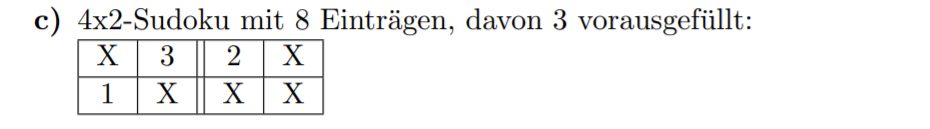

In [30]:
import utils
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


## Variablen Deklaration:
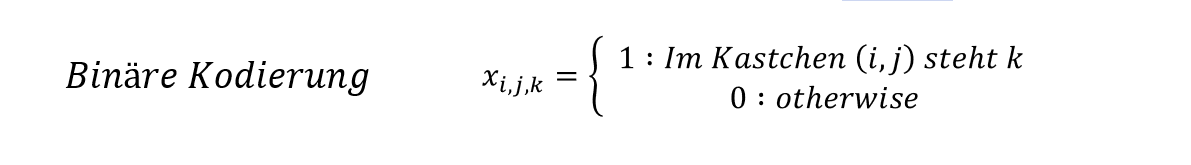

In [31]:
row_num = 2
column_num = 4
k_max = max(row_num, column_num)

num_sub_row = 2
num_sub_column = 1
block_size = 2

In [54]:
#Gewichte für Penalty funktions

alpha = 2
beta = 3
gamma = 3
delta = 3

In [55]:
# known values
known_vars = {}

known_vars[(0,1)] = 2
known_vars[(0,2)] = 1
known_vars[(1,0)] = 0


In [56]:
all_vars = utils.get_all_vars(row_num, column_num, k_max)
var_list = utils.get_unbekannte_vars(row_num, column_num, k_max, known_vars)
prunned_list = utils.get_prunned_vars(row_num, column_num, k_max, num_sub_row, num_sub_column, block_size, known_vars)

In [57]:
# prunned variable list
prunned_list

[(0, 0, 3),
 (0, 3, 0),
 (0, 3, 3),
 (1, 1, 1),
 (1, 1, 3),
 (1, 2, 2),
 (1, 2, 3),
 (1, 3, 2),
 (1, 3, 3)]

In [58]:
p_list = []
appender = []
remember = prunned_list[0]
for tupel in prunned_list:
    if (tupel[0] != remember[0] or tupel[1] != remember[1]):
        remember = tupel
        if (len(appender) > 1):
            for a in appender:
                p_list.append(a)
        else:
            known_vars[(appender[0][0], appender[0][1])] = appender[0][2]
        appender = []
        appender.append(tupel)
    else:
        appender.append(tupel)
        
if (len(appender) > 1):
    for a in appender:
        p_list.append(a)
else:
    known_vars[(appender[0][0], appender[0][1])] = appender[0][2]

In [59]:
len(p_list)

8

In [60]:
len(prunned_list)

9

In [61]:
prunned_list = p_list

-------

# Constraints and Penalty functions

In [62]:
n = len(prunned_list)
QUBO = np.zeros((n,n))

### Constraint 1: A single cell can only have one number

$$
\sum_{k=1}^{9} X_{i j k}=1, \quad \forall i j \in \text {cell}
$$

#### Here, we introduce a penalty weight $\alpha$.

$$
\alpha \sum_{i j}\left(\sum_{k=1}^{9} x_{i j k}-1\right)^{2}
$$

In [63]:
QUBO = utils.h1_penalty(alpha, QUBO, prunned_list)

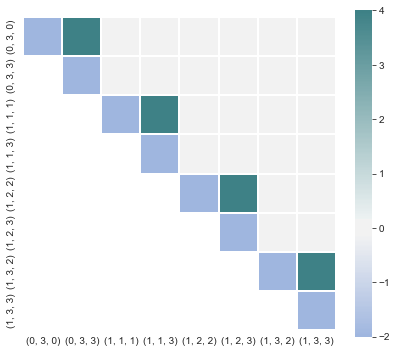

In [64]:
penalty = 'h1'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 2: Each column j can not have a duplicate number

$$
 \sum_{i} X_{i j k}=1, \quad \forall j \in \text { column }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\beta$.

$$
\beta \sum_{k=1}^{9} \sum_{j}\left(\sum_{i} x_{i j k}-1\right)^{2}
$$

In [65]:
QUBO = utils.h2_penalty(beta, QUBO, prunned_list, all_vars, known_vars)

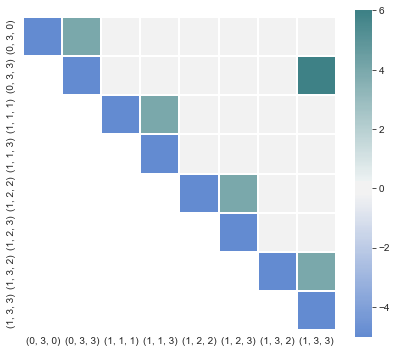

In [66]:
penalty = 'h2'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 3: Each column row i cannot have any duplicate number

$$
 \sum_{j} X_{i j k}=1, \quad \forall i \in \text { row }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\gamma$.

$$
\gamma \sum_{k=1}^{9} \sum_{i}\left(\sum_{j} x_{i j k}-1\right)^{2}
$$

In [67]:
QUBO = utils.h3_penalty(gamma, QUBO, prunned_list, all_vars, known_vars)

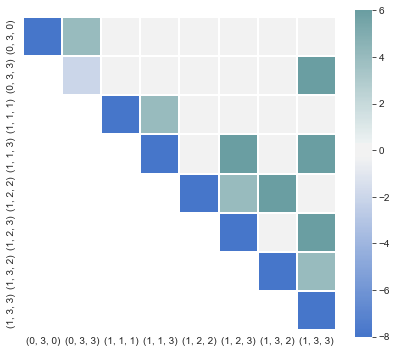

In [68]:
penalty = 'h3'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 4: Each of the subgrids cannot have any duplicate number

$$
\sum_{subgrid} x_{ijk}=1, \quad \forall k \in\{1 . .9\} \text{         } 
\forall subgrid 
$$


#### Here, we introduce a penalty weight $\delta$.

$$
\delta \sum_{k=1}^{9}\left(\sum_{subgrid} x_{ijk}-1\right)^{2}
$$

In [69]:
all_blocks = utils.get_all_blocks(num_sub_row, num_sub_column)

In [70]:
QUBO = utils.h4_penalty(delta, QUBO, prunned_list, all_vars, known_vars, block_size, all_blocks)

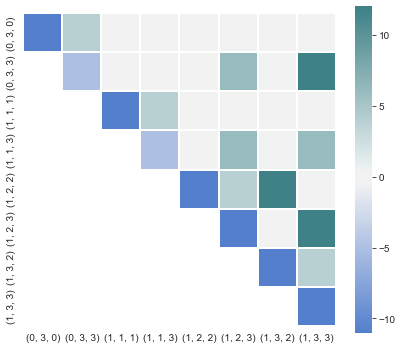

In [71]:
penalty = 'h4'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

--------

# Lösung mit QBSolve (Simulated Annealing)

In [72]:
qubo_d = utils.matrix_to_dictionary(QUBO)
sampleset = utils.on_QBsolve(qubo_d)

In [73]:
for sample in sampleset:
    result = [y for _, y in sample.items()]
    solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
    print(solution)
    print()

[[3. 2. 1. 0.]
 [0. 1. 2. 3.]]

[[3. 2. 1. 0.]
 [0. 1. 3. 2.]]



-----

# Lösung mit DWave (DWave Advantage)

In [89]:
dic = {}
dic['col1'] = sampleset.record.energy
dic['col2'] = sampleset.record.num_occurrences


import pandas as pd
df = pd.DataFrame.from_dict(dic)

In [90]:
df

,col1,col2
0,-44.0,414
1,-44.0,581
2,-40.0,4
3,-40.0,1


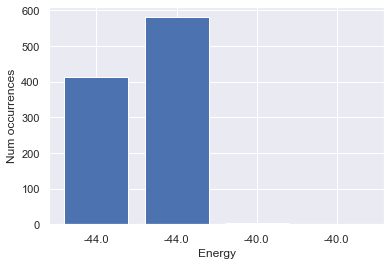

In [110]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt

# Make a random dataset:
energies = sampleset.record.energy
num_occ = sampleset.record.num_occurrences
y_pos = np.arange(len(energies))

# Create bars
plt.bar(y_pos, num_occ)

# Create names on the x-axis
plt.xticks(y_pos, energies)
plt.xlabel('Energy')
plt.ylabel('Num occurrences')
# Show graphic
#plt.show()
plt.savefig('dwave.jpg')

In [74]:
sampleset = utils.on_DWave(QUBO, 1000)

In [53]:
max_n = 5
for i, sample in enumerate(sampleset):
    if (i < max_n):
        result = [y for _, y in sample.items()]
        solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
        print(solution)
        print()

[[3. 2. 1. 0.]
 [0. 1. 3. 2.]]

[[3. 2. 1. 0.]
 [0. 1. 2. 3.]]

[[3. 2. 1. 3.]
 [0. 1. 3. 2.]]

[[3. 2. 1. 0.]
 [0. 3. 3. 2.]]

[[3. 2. 1. 0.]
 [0. 1. 3. 3.]]



----------

# Lösung mit QAOA (Qiskits QuadraticProgram)

In [25]:
quadr_program = utils.QUBO_to_QuadraticProgram(QUBO)
print(quadr_program)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 12 x0^2 + 4 x0*x1 - 4 x1^2 + 4 x1*x5 + 12 x1*x7 - 12 x2^2 + 4 x2*x3
      - 8 x3^2 + 8 x3*x5 + 8 x3*x7 - 12 x4^2 + 4 x4*x5 + 12 x4*x6 - 12 x5^2
      + 12 x5*x7 - 12 x6^2 + 4 x6*x7 - 12 x7^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1
 0 <= x6 <= 1
 0 <= x7 <= 1

Binaries
 x0 x1 x2 x3 x4 x5 x6 x7
End



optimal params:       {ParameterVectorElement(θ[0]): -2.8866652295224124, ParameterVectorElement(θ[1]): 2.655563665422913}
optimal value:        -7.231077797458019


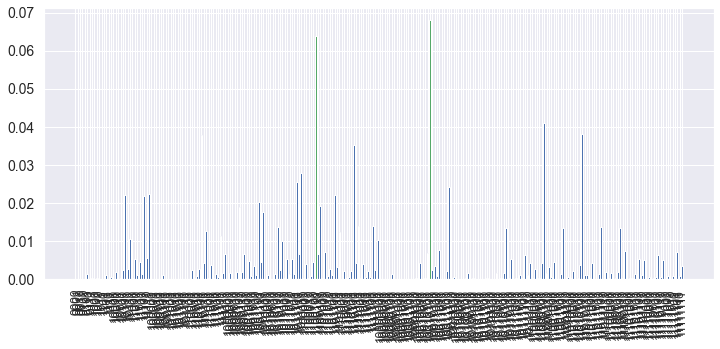

<generator object on_qiskit.<locals>.<genexpr> at 0x000001ADFCB4B200>


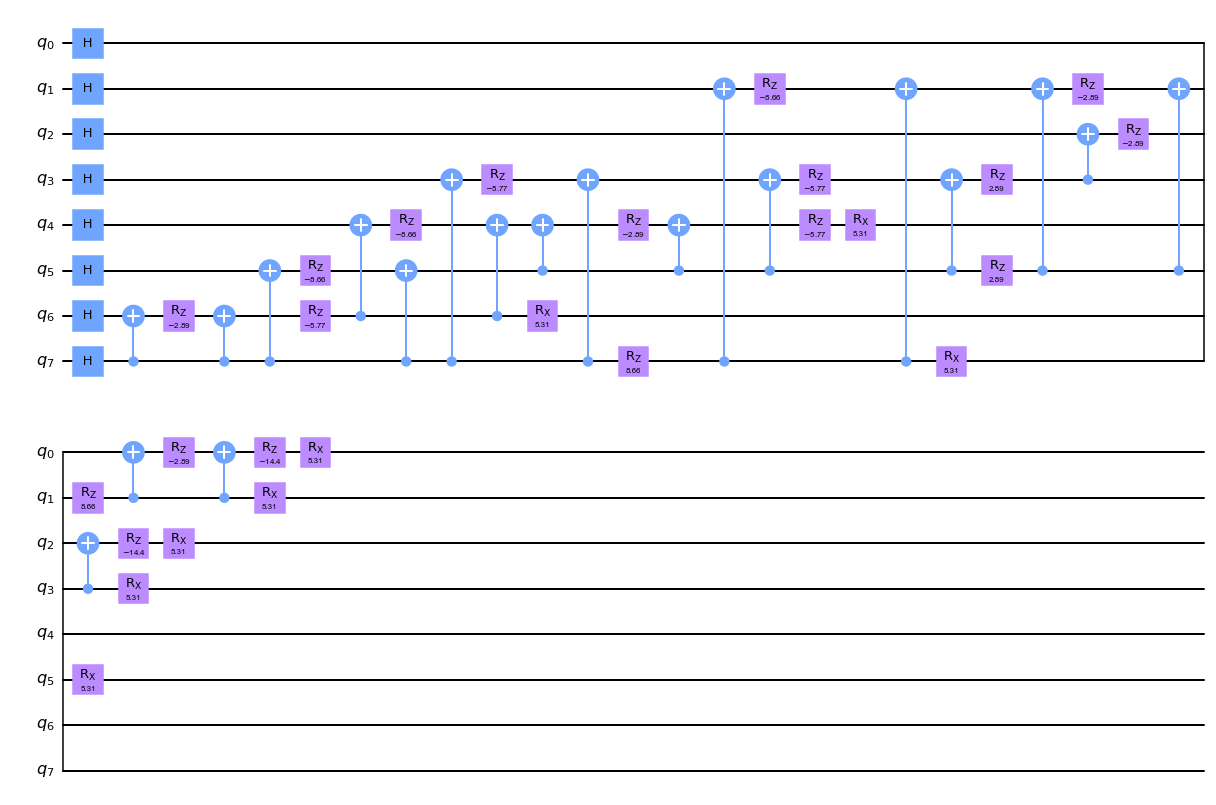

In [120]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')
qc = utils.on_qiskit(quadr_program, backend, with_graphic = True)[1]
display(qc.draw('mpl'))

In [118]:
from qiskit import QuantumCircuit, Aer, assemble, IBMQ, transpile
for kk in range(4):
    trans_qc = transpile(qc, basis_gates=['cx', 'u3'], optimization_level=kk)
    
    #display(trans_qc.draw())
    print('Optimization Level {}'.format(kk))
    print('Depth:', trans_qc.depth())
    print('Gate counts:', trans_qc.count_ops())

Optimization Level 0
Depth: 24
Gate counts: OrderedDict([('u3', 34), ('cx', 20)])
Optimization Level 1
Depth: 23
Gate counts: OrderedDict([('u3', 31), ('cx', 20)])
Optimization Level 2
Depth: 23
Gate counts: OrderedDict([('u3', 31), ('cx', 20)])
Optimization Level 3
Depth: 23
Gate counts: OrderedDict([('u3', 31), ('cx', 20)])


In [28]:
trans_qc.count_ops()['u3'] + 10 * trans_qc.count_ops()['cx']

231

In [29]:
costs = utils.get_costs(qc)

OrderedDict([('u3', 34), ('cx', 20)])
Cost: 234


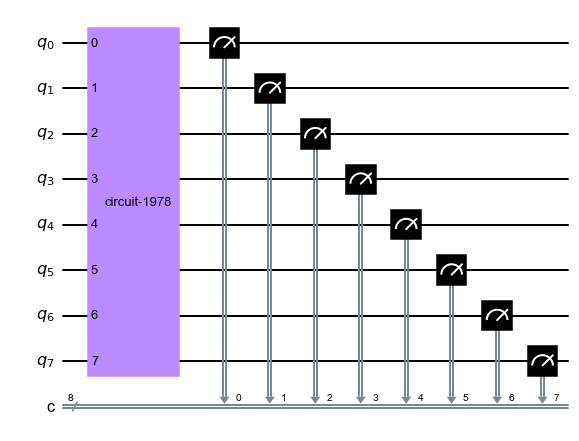

In [114]:
backend = Aer.get_backend('qasm_simulator')
counts = utils.measure_ciruit(qc, backend, shots = 1000)
result = counts.most_frequent()

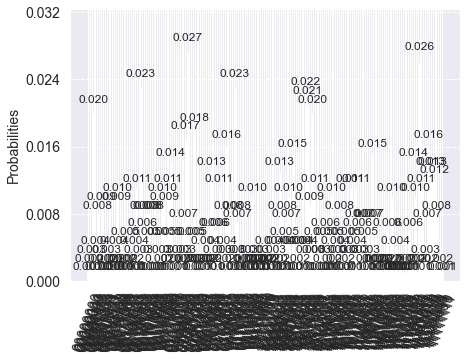

In [115]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [116]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)

[[3. 2. 1. 3.]
 [0. 1. 3. 2.]]
